In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle as pkl
from sklearn import metrics
from skimage.filters.rank import entropy
from skimage.morphology import disk
import time
import torch

from vsa_ogm.metrics import calculate_multiple_TP_FP_rates

/home/snyd962/anaconda3/envs/spl-venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
base_dir = "/home/snyd962/dev/highfrost/highfrost/ogm/experiments/logs"
a1_base_dir = os.path.join(base_dir, "build_vsa_map_intel_q1")
a2_base_dir = os.path.join(base_dir, "build_vsa_map_intel_q2")
a3_base_dir = os.path.join(base_dir, "build_vsa_map_intel_q3")
a4_base_dir = os.path.join(base_dir, "build_vsa_map_intel_q4")

device = "cuda:3" if torch.cuda.is_available() else "cpu"

paths: dict = {
    "agent1": {
        "axis_vectors": os.path.join(a1_base_dir, "xy_axis_vectors.npy"),
        "occ_mvs": os.path.join(a1_base_dir, "observations", "observation_219", "occupied_quadrant_memory_vectors.npy"),
        "empty_mvs": os.path.join(a1_base_dir, "observations", "observation_219", "empty_quadrant_memory_vectors.npy"),
    },
    "agent2": {
        "axis_vectors": os.path.join(a2_base_dir, "xy_axis_vectors.npy"),
        "occ_mvs": os.path.join(a2_base_dir, "observations", "observation_158", "occupied_quadrant_memory_vectors.npy"),
        "empty_mvs": os.path.join(a2_base_dir, "observations", "observation_158", "empty_quadrant_memory_vectors.npy"),
    },
    "agent3": {
        "axis_vectors": os.path.join(a3_base_dir, "xy_axis_vectors.npy"),
        "occ_mvs": os.path.join(a3_base_dir, "observations", "observation_280", "occupied_quadrant_memory_vectors.npy"),
        "empty_mvs": os.path.join(a3_base_dir, "observations", "observation_280", "empty_quadrant_memory_vectors.npy"),
    },
    "agent4": {
        "axis_vectors": os.path.join(a4_base_dir, "xy_axis_vectors.npy"),
        "occ_mvs": os.path.join(a4_base_dir, "observations", "observation_241", "occupied_quadrant_memory_vectors.npy"),
        "empty_mvs": os.path.join(a4_base_dir, "observations", "observation_241", "empty_quadrant_memory_vectors.npy"),
    },
}



#### Validate the axis vectors between all agents are equivalent

In [3]:
a1_xy_axis_vectors = np.load(paths["agent1"]["axis_vectors"])
a2_xy_axis_vectors = np.load(paths["agent2"]["axis_vectors"])
a3_xy_axis_vectors = np.load(paths["agent3"]["axis_vectors"])
a4_xy_axis_vectors = np.load(paths["agent4"]["axis_vectors"])

assert a1_xy_axis_vectors.shape == a2_xy_axis_vectors.shape
assert a3_xy_axis_vectors.shape == a4_xy_axis_vectors.shape
assert a1_xy_axis_vectors.shape == a3_xy_axis_vectors.shape
assert a1_xy_axis_vectors.shape[0] == a2_xy_axis_vectors.shape[0]
assert a1_xy_axis_vectors.shape[1] == a2_xy_axis_vectors.shape[1]
assert a3_xy_axis_vectors.shape[0] == a4_xy_axis_vectors.shape[0]
assert a3_xy_axis_vectors.shape[1] == a4_xy_axis_vectors.shape[1]
assert a1_xy_axis_vectors.shape[0] == a3_xy_axis_vectors.shape[0]
assert a1_xy_axis_vectors.shape[1] == a3_xy_axis_vectors.shape[1]
assert np.equal(a1_xy_axis_vectors, a2_xy_axis_vectors).all()
assert np.equal(a3_xy_axis_vectors, a4_xy_axis_vectors).all()
assert np.equal(a1_xy_axis_vectors, a3_xy_axis_vectors).all()

#### Load the global xy axis matrix

In [4]:
xy_axis_matrix_path = "/home/snyd962/dev/highfrost/highfrost/ogm/experiments/logs/build_vsa_map_intel_q1/xy_axis_matrix.npy"
xy_axis_matrix = np.load(xy_axis_matrix_path)
xy_axis_matrix = torch.from_numpy(xy_axis_matrix)
xy_axis_matrix = xy_axis_matrix.to(device)

#### Load the occupied quadrant memories

In [5]:
a1_occupied_quadrant_memory_vectors = np.load(paths["agent1"]["occ_mvs"])
a2_occupied_quadrant_memory_vectors = np.load(paths["agent2"]["occ_mvs"])
a3_occupied_quadrant_memory_vectors = np.load(paths["agent3"]["occ_mvs"])
a4_occupied_quadrant_memory_vectors = np.load(paths["agent4"]["occ_mvs"])

a1_occupied_quadrant_memory_vectors = torch.from_numpy(a1_occupied_quadrant_memory_vectors).to(device)
a2_occupied_quadrant_memory_vectors = torch.from_numpy(a2_occupied_quadrant_memory_vectors).to(device)
a3_occupied_quadrant_memory_vectors = torch.from_numpy(a3_occupied_quadrant_memory_vectors).to(device)
a4_occupied_quadrant_memory_vectors = torch.from_numpy(a4_occupied_quadrant_memory_vectors).to(device)


assert a1_occupied_quadrant_memory_vectors.shape == a2_occupied_quadrant_memory_vectors.shape
assert a3_occupied_quadrant_memory_vectors.shape == a4_occupied_quadrant_memory_vectors.shape
assert a1_occupied_quadrant_memory_vectors.shape == a3_occupied_quadrant_memory_vectors.shape

#### Load the empty quadrant memories

In [6]:
a1_empty_quadrant_memory_vectors = np.load(paths["agent1"]["empty_mvs"])
a2_empty_quadrant_memory_vectors = np.load(paths["agent2"]["empty_mvs"])
a3_empty_quadrant_memory_vectors = np.load(paths["agent3"]["empty_mvs"])
a4_empty_quadrant_memory_vectors = np.load(paths["agent4"]["empty_mvs"])

a1_empty_quadrant_memory_vectors = torch.from_numpy(a1_empty_quadrant_memory_vectors).to(device)
a2_empty_quadrant_memory_vectors = torch.from_numpy(a2_empty_quadrant_memory_vectors).to(device)
a3_empty_quadrant_memory_vectors = torch.from_numpy(a3_empty_quadrant_memory_vectors).to(device)
a4_empty_quadrant_memory_vectors = torch.from_numpy(a4_empty_quadrant_memory_vectors).to(device)

assert a1_empty_quadrant_memory_vectors.shape == a2_empty_quadrant_memory_vectors.shape
assert a3_empty_quadrant_memory_vectors.shape == a4_empty_quadrant_memory_vectors.shape
assert a1_empty_quadrant_memory_vectors.shape == a3_empty_quadrant_memory_vectors.shape

#### Calculate the global quadrant memories

In [7]:
start_time = time.time()

global_occ_qmvs = torch.add(a1_occupied_quadrant_memory_vectors, a2_occupied_quadrant_memory_vectors)
global_occ_qmvs = torch.add(global_occ_qmvs, a3_occupied_quadrant_memory_vectors)
global_occ_qmvs = torch.add(global_occ_qmvs, a4_occupied_quadrant_memory_vectors)

global_empty_qmvs = torch.add(a1_empty_quadrant_memory_vectors, a2_empty_quadrant_memory_vectors)
global_empty_qmvs = torch.add(global_empty_qmvs, a3_empty_quadrant_memory_vectors)
global_empty_qmvs = torch.add(global_empty_qmvs, a4_empty_quadrant_memory_vectors)

print(f"Total Time: {time.time() - start_time}")

Total Time: 0.00028896331787109375


### Load Quadrant Indices

In [8]:
quadrant_indices_x_path: str = "/home/snyd962/dev/highfrost/quadrant_indices_x.npy"
quadrant_indices_y_path: str = "/home/snyd962/dev/highfrost/quadrant_indices_y.npy"

quadrant_indices_x = np.load(quadrant_indices_x_path)
quadrant_indices_y = np.load(quadrant_indices_y_path)

quadrant_indices_x = torch.from_numpy(quadrant_indices_x).to(device)
quadrant_indices_y = torch.from_numpy(quadrant_indices_y).to(device)

In [46]:
global_empty_xy_axis_heatmap = torch.zeros(
    size=(xy_axis_matrix.shape[0], xy_axis_matrix.shape[1])
).to(device)

#### Calculate the global empty probability heatmap
start_time = time.time()

counter = 0
for j, y_lower in enumerate(quadrant_indices_y[:-1]):
    for i, x_lower in enumerate(quadrant_indices_x[:-1]):
        x_upper = quadrant_indices_x[i + 1]
        y_upper = quadrant_indices_y[j + 1]

        xy_axis_matrix_quad = xy_axis_matrix[x_lower:x_upper, y_lower:y_upper, :]

        qv = global_empty_qmvs[counter, :]
        qv /= torch.linalg.norm(qv)

        quadrant_heatmap = torch.tensordot(
            qv,
            xy_axis_matrix_quad,
            dims=([0], [2])
        )

        quadrant_heatmap /= torch.max(quadrant_heatmap)

        global_empty_xy_axis_heatmap[x_lower:x_upper, y_lower:y_upper] = quadrant_heatmap
        
        counter += 1

print(f"Total Time: {time.time() - start_time}")

global_empty_xy_axis_heatmap = global_empty_xy_axis_heatmap.T

Total Time: 0.5134701728820801


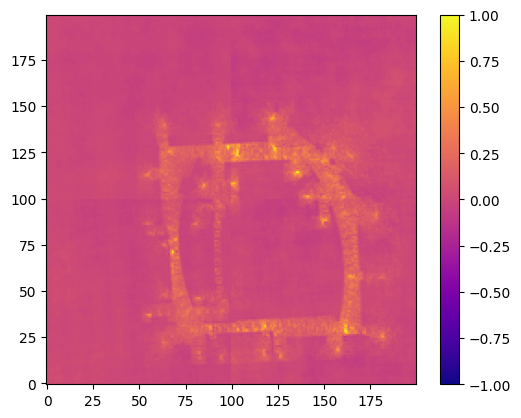

In [70]:
plt.imshow(global_empty_xy_axis_heatmap.cpu().numpy(), cmap="plasma", origin="lower")
plt.colorbar()
plt.clim(-1, 1)
plt.savefig("global_empty_hm.png", dpi=500)

Total Time: 0.031525373458862305
3.7004397181410926
0.0


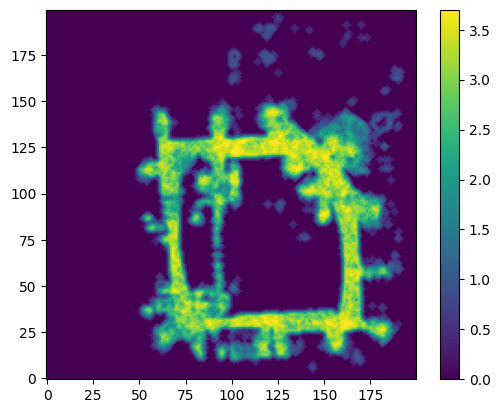

In [48]:
disk_size = 2

start_time = time.time()
empty_hm_cpu = global_empty_xy_axis_heatmap.cpu().numpy()
global_empty_image = np.square(empty_hm_cpu)
global_empty_image *= 255.0
global_empty_image = global_empty_image.astype(np.uint8)

global_empty_entropy = entropy(global_empty_image, disk(disk_size))

print(f"Total Time: {time.time() - start_time}")

print(np.max(global_empty_entropy))
print(np.min(global_empty_entropy))

plt.imshow(global_empty_entropy, origin="lower")
plt.colorbar()
plt.savefig("global_empty_entropy.png", dpi=500)

#### Calculate the global occupancy probability

In [12]:
#### Calculate the global empty probability heatmap
global_occ_xy_axis_heatmap = torch.zeros(
    size=(xy_axis_matrix.shape[0], xy_axis_matrix.shape[1])
).to(device)

#### Calculate the global empty probability heatmap
start_time = time.time()

counter = 0
for j, y_lower in enumerate(quadrant_indices_y[:-1]):
    for i, x_lower in enumerate(quadrant_indices_x[:-1]):
        x_upper = quadrant_indices_x[i + 1]
        y_upper = quadrant_indices_y[j + 1]

        xy_axis_matrix_quad = xy_axis_matrix[x_lower:x_upper, y_lower:y_upper, :]

        qv = global_occ_qmvs[counter, :]
        qv /= torch.linalg.norm(qv)

        quadrant_heatmap = torch.tensordot(
            qv,
            xy_axis_matrix_quad,
            dims=([0], [2])
        )

        quadrant_heatmap /= torch.max(quadrant_heatmap)

        global_occ_xy_axis_heatmap[x_lower:x_upper, y_lower:y_upper] = quadrant_heatmap
        
        counter += 1

print(f"Total Time: {time.time() - start_time}")

global_occ_xy_axis_heatmap = global_occ_xy_axis_heatmap.T

Total Time: 0.5054564476013184


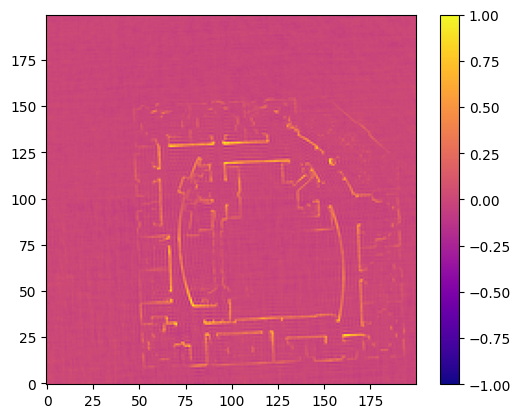

In [69]:
plt.imshow(global_occ_xy_axis_heatmap.cpu().numpy(), cmap="plasma", origin="lower")
plt.colorbar()
plt.clim(-1, 1)
plt.savefig("global_occ_hm.png", dpi=500)

Total Time: 0.015549421310424805
2.3219280948873626
0.0


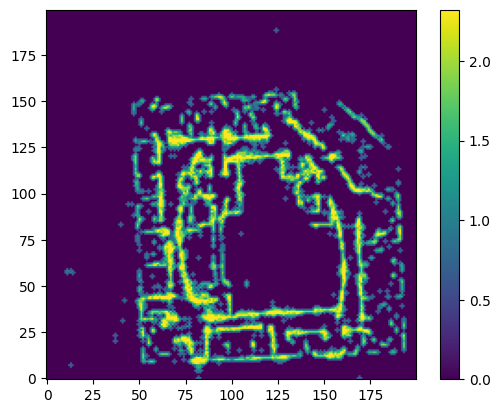

In [51]:
disk_size = 1

start_time = time.time()
occ_hm_cpu = global_occ_xy_axis_heatmap.cpu().numpy()
global_occ_image = np.square(occ_hm_cpu)
global_occ_image *= 255.0
global_occ_image = global_occ_image.astype(np.uint8)

global_occ_entropy = entropy(global_occ_image, disk(disk_size))

print(f"Total Time: {time.time() - start_time}")

print(np.max(global_occ_entropy))
print(np.min(global_occ_entropy))

plt.imshow(global_occ_entropy, origin="lower")
plt.colorbar()
plt.savefig("global_occ_entropy.png", dpi=500)

Total Time: 0.00027298927307128906
2.3219280948873626
-3.7004397181410926


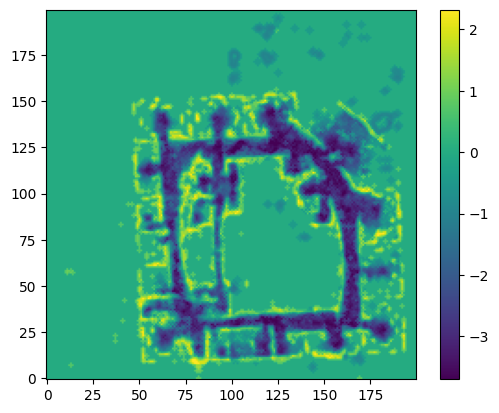

In [57]:
start_time = time.time()

global_entropy = global_occ_entropy - global_empty_entropy

end_time = time.time()

print(f"Total Time: {end_time - start_time}")

print(np.max(global_entropy))
print(np.min(global_entropy))

plt.imshow(global_entropy, origin="lower")
plt.colorbar()
plt.savefig("global_entropy.png", dpi=500)

#### Evaluate the performance across all of the test sets

In [60]:
a1_td_path = "/home/snyd962/dev/highfrost/highfrost/ogm/experiments/logs/build_vsa_map_intel_q1/test_data.pkl"
a2_td_path = "/home/snyd962/dev/highfrost/highfrost/ogm/experiments/logs/build_vsa_map_intel_q2/test_data.pkl"
a3_td_path = "/home/snyd962/dev/highfrost/highfrost/ogm/experiments/logs/build_vsa_map_intel_q3/test_data.pkl"
a4_td_path = "/home/snyd962/dev/highfrost/highfrost/ogm/experiments/logs/build_vsa_map_intel_q4/test_data.pkl"

with open(a1_td_path, "rb") as f:
    a1_test_data = pkl.load(f)

with open(a2_td_path, "rb") as f:
    a2_test_data = pkl.load(f)

with open(a3_td_path, "rb") as f:
    a3_test_data = pkl.load(f)

with open(a4_td_path, "rb") as f:
    a4_test_data = pkl.load(f)

Num Threshold Steps: 603


Text(0, 0.5, 'Threshold Values')

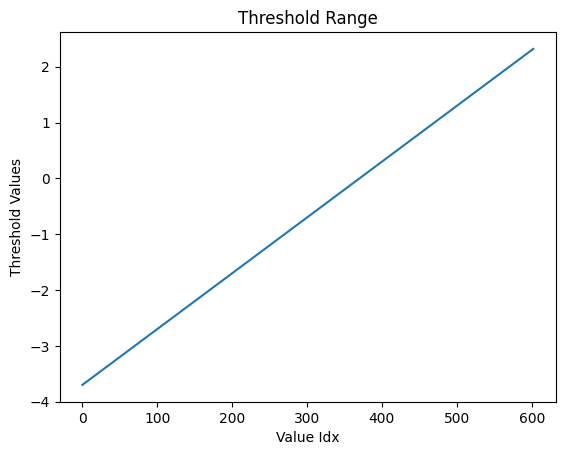

In [61]:
threshold_min = np.min(global_entropy)
threshold_max = np.max(global_entropy)
threshold_step_size = 0.01
threshold_range = np.arange(threshold_min, threshold_max, threshold_step_size)
print(f"Num Threshold Steps: {threshold_range.shape[0]}")

plt.plot(threshold_range)
plt.title("Threshold Range")
plt.xlabel("Value Idx")
plt.ylabel("Threshold Values")

In [62]:
world_size = [-20, 20, -25, 15]
axis_resolution = 0.2

def calculate_preds_w_threshold_test(ge: np.ndarray, threshold: float, dataset):
    
    lidar_data = dataset["lidar_data"][::2]
    occupancy = dataset["occupancy"][::2]

    labels_gt: list[np.ndarray] = []
    preds_list: list[np.ndarray] = []

    for i in range(len(lidar_data)):
        
        points = lidar_data[i]
        labels = occupancy[i]

        points = points[points[:,0] >= world_size[0], :]
        points = points[points[:,0] <= world_size[1], :]
        points = points[points[:,1] >= world_size[2], :]
        points = points[points[:,1] <= world_size[3], :]
        labels = labels[points[:,0] >= world_size[0]]
        labels = labels[points[:,0] <= world_size[1]]
        labels = labels[points[:,1] >= world_size[2]]
        labels = labels[points[:,1] <= world_size[3]]  

        assert points.shape[0] == labels.shape[0]
        assert points.shape[0] > 0

        points[:, 0] -= world_size[0]
        points[:, 1] -= world_size[2]
        points /= axis_resolution
        points = points.astype(np.uint8)

        assert points.shape[0] == labels.shape[0]
        assert points.shape[0] > 0

        e_values = ge[points[:, 1], points[:, 0]]

        assert e_values.shape[0] == points.shape[0]
        
        preds = np.zeros(shape=(points.shape[0]))
        preds[e_values > threshold] = 1

        assert preds.shape[0] == points.shape[0]

        labels_gt.append(labels)
        preds_list.append(preds)

    return np.concatenate(labels_gt), np.concatenate(preds_list)

In [63]:
global_data_y_true: list[np.ndarray] = []
global_data_y_pred: list[np.ndarray] = []

global_test_data = copy.deepcopy(a1_test_data)
global_test_data["lidar_data"] = []
global_test_data["occupancy"] = []

for i in range(len(a1_test_data["lidar_data"])):
    global_test_data["lidar_data"].append(a1_test_data["lidar_data"][i])
    global_test_data["occupancy"].append(a1_test_data["occupancy"][i])

for i in range(len(a2_test_data["lidar_data"])):
    global_test_data["lidar_data"].append(a2_test_data["lidar_data"][i])
    global_test_data["occupancy"].append(a2_test_data["occupancy"][i])

for i in range(len(a3_test_data["lidar_data"])):
    global_test_data["lidar_data"].append(a3_test_data["lidar_data"][i])
    global_test_data["occupancy"].append(a3_test_data["occupancy"][i])

for i in range(len(a4_test_data["lidar_data"])):
    global_test_data["lidar_data"].append(a4_test_data["lidar_data"][i])
    global_test_data["occupancy"].append(a4_test_data["occupancy"][i])

for t in threshold_range:
    true, pred = calculate_preds_w_threshold_test(global_entropy, t, global_test_data)
    
    global_data_y_true.append(true)
    global_data_y_pred.append(pred)

In [64]:
tpr_list, fpr_list = calculate_multiple_TP_FP_rates(global_data_y_true, global_data_y_pred)

In [65]:
auc = metrics.auc(fpr_list, tpr_list)

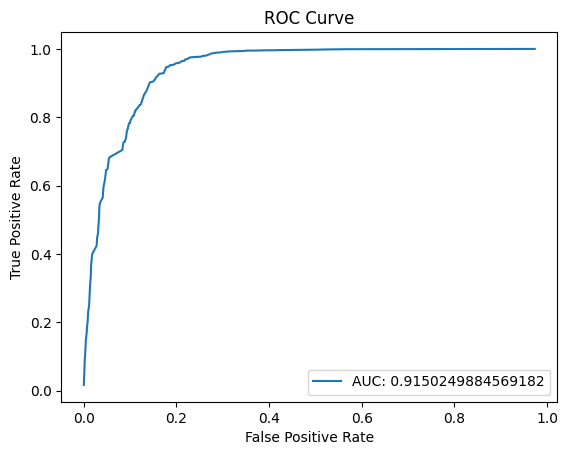

In [66]:
plt.plot(fpr_list, tpr_list, label=f"AUC: {auc}")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.savefig("global-roc-curve.png", dpi=500)

In [67]:
import os

BASE_CONFIG: dict = {
    "experiment_name": "build_vsa_map",
    "verbose": True,
    "data": {
        "dataset_name": "intel", # toysim, intel
        "test_split": 0.1,
        "toysim": {
            "data_dir": os.path.expanduser("~") + "/dev/highfrost/highfrost/ogm/datasets/fusion/toysim/toysim_agent2",
            "file_prefix": "results_frame_",
            "file_suffix": ".npz",
            "world_bounds": [-50, 50, -50, 50] # x_min, x_max, y_min, y_max; meters
        },
        "intel": {
            "data_dir": os.path.expanduser("~") + "/dev/highfrost/highfrost/ogm/datasets/single/intel.csv",
            "world_bounds": [-20, 20, -25, 15] # x_min, x_max, y_min, y_max; meters
        },
    },
    "logging": {
        "log_dir": os.path.expanduser("~") + "/dev/highfrost/highfrost/ogm/experiments/logs",
        "occupied_map_dir": "occupied_maps",
        "empty_map_dir": "empty_maps",
        "global_maps_dir": "global_maps",
        "run_time_metrics": "run_time_metrics.pkl"
    }
}

import vsa_ogm.dataloaders.functional as hogmf
from omegaconf import DictConfig

config: DictConfig = DictConfig(BASE_CONFIG)

Loading Data...
0.8379310795788923


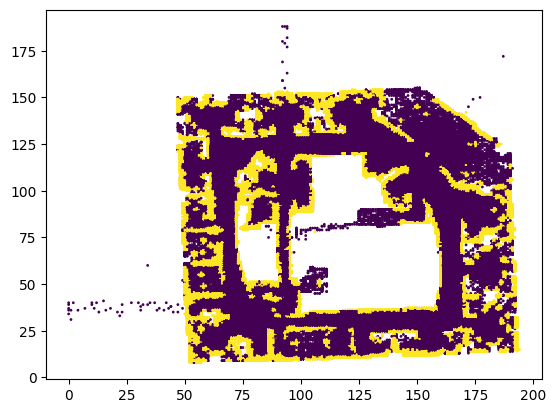

In [68]:
dataloader, world_size = hogmf.load_single_data(config)

output = dataloader.reset()
num_correct: int = 0
num_total: int = 0

plt.clf()

for i in range(dataloader.max_steps())[:-2]:
    
    points = output["lidar_data"]
    labels = output["occupancy"]

    points[:, 0] -= world_size[0]
    points[:, 1] -= world_size[2]

    points /= axis_resolution

    points = points.astype(np.uint8)

    # m1 = points[:, 0] <= 199
    # m2 = points[:, 1] <= 199
    # m3 = np.logical_and(m1, m2)

    # points = points[m3, :]
    # labels = labels[m3]

    occ_values = global_occ_entropy[points[:, 1], points[:, 0]]
    empty_values = global_empty_entropy[points[:, 1], points[:, 0]]

    preds = np.zeros(shape=(points.shape[0]))
    preds[occ_values > empty_values] = 1
    preds[occ_values <= empty_values] = 0

    num_total += points.shape[0]
    num_correct += points[preds == labels].shape[0]

    plt.scatter(points[:, 0], points[:, 1], c=preds, s=1)
    
    output = dataloader.step()

print(num_correct / num_total)
plt.savefig("global-preds.png", dpi=500)